In [1]:
import os
import json

def get_data(folder_name):
    x = []
    y = []
    positions = []
    file_names = []

    for file in os.listdir(folder_name):
        if file.endswith(".txt"):
            file_name = os.path.join(folder_name, file[:-4])

            file_text = open(file_name + '.txt', encoding='utf8')
            try:
                file_truth = open(file_name + '.truth', encoding='utf8')

                try:
                    text = file_text.read()
                    truth = json.load(file_truth)
                    truth_changes = truth['changes']
                    truth_positions = truth['positions']

                    x.append(text)
                    y.append(truth_changes)
                    positions.append(truth_positions)
                    file_names.append(file[:-4])
                finally:
                    file_truth.close()
            finally:
                file_text.close()

    return x, y, positions, file_names

In [2]:
from nltk.tokenize import sent_tokenize
def custom_sent_tokenize(text):
    sentences = []
    paragraphs = [p for p in text.split('\n') if p]
    for paragraph in paragraphs:
        sentences.extend(sent_tokenize(paragraph))
        
    return sentences

In [3]:
import pandas as pd

TRAINING_DIR = '../data/training'

X, y, positions, file_names = get_data(
    TRAINING_DIR)
df = pd.DataFrame(data={'text': X, 'label': y, 'filename': file_names, 'pos':positions})
df['num_sent'] = [len(custom_sent_tokenize(d)) for d in df.text]
df['num_splits'] = [len(x) for x in df.pos]

In [4]:
df.head()

,filename,label,pos,text,num_sent,num_splits
0,problem-1410,True,"[1683, 2890]",Make up some more tasks and add them to the qu...,41,2
1,problem-2252,False,[],"Yes, there were extensive rapes by American so...",44,0
2,problem-184,False,[],Observers highlight key things that are occurr...,27,0
3,problem-42,False,[],TL;DR Much of Scrum's value to an organization...,38,0
4,problem-2814,False,[],Origen believed (Contra Celsum 8) that while C...,30,0


In [5]:
names = ['digits', 'punctuation_count', 'comma_count', 'semicolon_count', 'colon_count', \
        'pronouns', 'prepositions', 'coordinating_conjunctions', 'adjectives', 'adverbs', \
         'determiners', 'interjections', 'modals', 'nouns', 'personal_pronouns', 'verbs', \
         'mean_word_length', 'word_len_gte_six', 'word_len_two_and_three', 'mean_sentence_length']

In [6]:
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag

def lexical_chars(df):    
    for i, entry in enumerate(df.text):
        digits, puncs, commas, semicolons, colons, mean_sentence_length = ([] for i in range(6))
        for sent in custom_sent_tokenize(entry):
            chars = list(sent)        
            char_count = len(chars)
            
            digits.append(sum(c.isdigit() for c in chars)/char_count)
            puncs.append(sum(c in '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~' for c in chars)/char_count)
            commas.append(chars.count(',')/ char_count)
            semicolons.append(chars.count(';')/char_count)
            colons.append(chars.count(':')/char_count)

        
        df.iloc[i,df.columns.get_loc('digits')]=max(digits) - min(digits)        
        df.iloc[i,df.columns.get_loc('punctuation_count')]=max(puncs) - min(puncs)
        df.iloc[i,df.columns.get_loc('comma_count')]=max(commas) - min(commas)
        df.iloc[i,df.columns.get_loc('semicolon_count')]=max(semicolons) - min(semicolons)
        df.iloc[i,df.columns.get_loc('colon_count')]=max(colons) - min(colons)

def lexical_words(df):
    for i, entry in enumerate(df.text):
        personal_pronouns, adjectives, nouns, verbs, pronouns, prepositions, coordinating_conjunctions, \
        adverbs, determiners, interjections, modals, word_len_gte_six, word_len_two_and_three, mean_word_length, \
        mean_sentence_length = ([] for i in range(15))
        for sent in custom_sent_tokenize(entry):
            words = word_tokenize(sent)
            words_tagged = pos_tag(words)        
            word_count = len(words_tagged)
            
            mean_sentence_length.append(len(sent))
            personal_pronouns.append(sum(t[1] in ['PRP'] for t in words_tagged)/word_count)
            adjectives.append(sum(t[1].startswith('J') for t in words_tagged)/word_count)
            nouns.append(sum(t[1].startswith('N') for t in words_tagged)/word_count)
            verbs.append(sum(t[1].startswith('V') for t in words_tagged)/word_count)
            pronouns.append(sum(t[1] in ['PRP', 'PRP$', 'WP', 'WP$'] for t in words_tagged)/word_count)
            prepositions.append(sum(t[1] in ['IN'] for t in words_tagged)/word_count)
            coordinating_conjunctions.append(sum(t[1] in ['CC'] for t in words_tagged)/word_count)
            adverbs.append(sum(t[1] in ['RB', 'RBR', 'RBS'] for t in words_tagged)/word_count)
            determiners.append(sum(t[1] in ['DT', 'PDT', 'WDT'] for t in words_tagged)/word_count)
            interjections.append(sum(t[1] in ['UH'] for t in words_tagged)/word_count)
            modals.append(sum(t[1] in ['MD'] for t in words_tagged)/word_count)
            word_len_gte_six.append(sum(len(w) >= 6 for w in words)/word_count)
            word_len_two_and_three.append(sum(len(w) in [2, 3] for w in words)/word_count)
            mean_word_length.append(sum(len(w) for w in words)/word_count)

            
        df.iloc[i,df.columns.get_loc('mean_sentence_length')]=max(mean_sentence_length) - min(mean_sentence_length)
        df.iloc[i,df.columns.get_loc('personal_pronouns')]=max(personal_pronouns) - min(personal_pronouns)
        df.iloc[i,df.columns.get_loc('adjectives')]=max(adjectives) - min(adjectives)  
        df.iloc[i,df.columns.get_loc('nouns')]=max(nouns) - min(nouns)
        df.iloc[i,df.columns.get_loc('verbs')]=max(verbs) - min(verbs)
        df.iloc[i,df.columns.get_loc('pronouns')]=max(pronouns) - min(pronouns)
        df.iloc[i,df.columns.get_loc('prepositions')]=max(prepositions) - min(prepositions)    
        df.iloc[i,df.columns.get_loc('coordinating_conjunctions')]=max(coordinating_conjunctions) - min(coordinating_conjunctions)
        df.iloc[i,df.columns.get_loc('adverbs')]=max(adverbs) - min(adverbs)
        df.iloc[i,df.columns.get_loc('determiners')]=max(determiners) - min(determiners)
        df.iloc[i,df.columns.get_loc('interjections')]=max(interjections) - min(interjections)
        df.iloc[i,df.columns.get_loc('modals')]= max(modals) - min(modals)
        df.iloc[i,df.columns.get_loc('word_len_gte_six')]= max(word_len_gte_six) - min(word_len_gte_six)
        df.iloc[i,df.columns.get_loc('word_len_two_and_three')]=  max(word_len_two_and_three) - min(word_len_two_and_three)
        df.iloc[i,df.columns.get_loc('mean_word_length')]=max(mean_word_length) - min(mean_word_length)
        

def lexical(df):
    for n in names:
        df[n] = np.zeros(len(df.text))
        
    lexical_chars(df)
    lexical_words(df)

In [7]:
lexical(df)

In [8]:
df=df[np.abs(df.mean_word_length-df.mean_word_length.mean())<=(4*df.mean_word_length.std())]

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
df1=df[names]
X = df1.values
X=scaler.fit_transform(X)
from sklearn.feature_selection import SelectKBest, chi2
ch2 = SelectKBest(chi2, k=10).fit(X, df.label)
X_train = ch2.transform(X)
best = [names[i] for i in ch2.get_support(indices=True)]

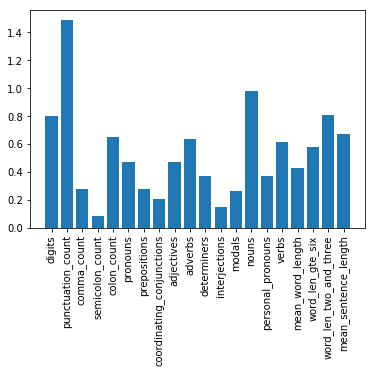

In [35]:
scores = -np.log10(ch2.pvalues_)
plt.bar(range(len(names)), scores)
plt.xticks(range(len(names)), names, rotation='vertical')
plt.show()

In [37]:
np.mean(ch2.scores_)

1.1852526751755925

In [39]:
best

['digits',
 'punctuation_count',
 'colon_count',
 'adjectives',
 'adverbs',
 'nouns',
 'verbs',
 'word_len_gte_six',
 'word_len_two_and_three',
 'mean_sentence_length']

<Figure size 432x288 with 0 Axes>

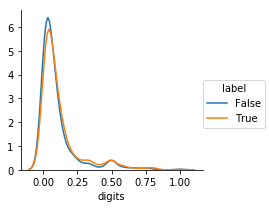

<Figure size 432x288 with 0 Axes>

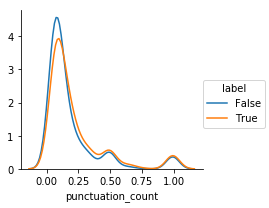

<Figure size 432x288 with 0 Axes>

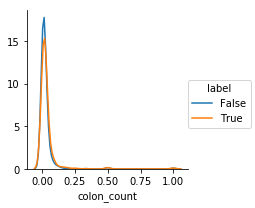

<Figure size 432x288 with 0 Axes>

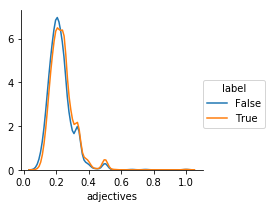

<Figure size 432x288 with 0 Axes>

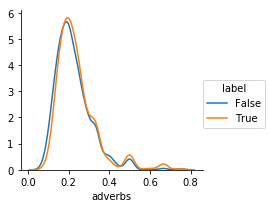

<Figure size 432x288 with 0 Axes>

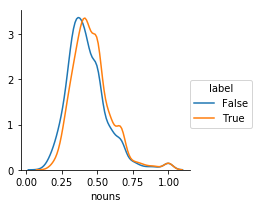

<Figure size 432x288 with 0 Axes>

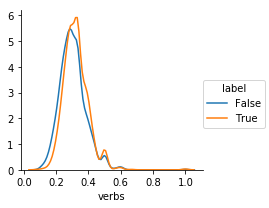

<Figure size 432x288 with 0 Axes>

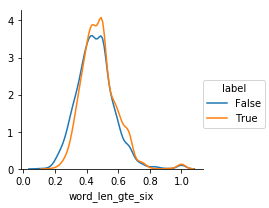

<Figure size 432x288 with 0 Axes>

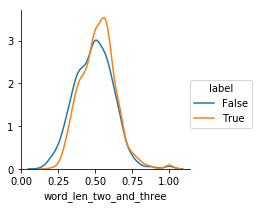

<Figure size 432x288 with 0 Axes>

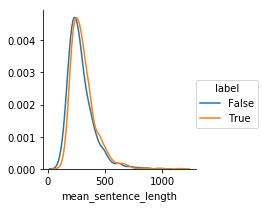

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
for name in best:
    plt.figure()
    sns.FacetGrid(df, hue="label") \
       .map(sns.kdeplot, name) \
       .add_legend()